<a href="https://colab.research.google.com/github/joshtburdick/misc/blob/master/plog/Factoring3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Further attempt at factoring

This is to test a simpler variant of the factoring method using loopy belief propagation. But without the loopy belief propagation.

The main idea is, given $n$, to solve $n=(a+b)(a-b) \mod m$, where $m = \prod p_i$ for $P$ (smallish) primes. Then check $\mathrm{GCD}(n, x)$ for $2^{2P}$ numbers $x$ which are derived from $a$ and $b$ using the Chinese Remainder Theorem.

N.B.: This seems fairly impractical, as it requires computing GCD $2^{2P}$ times, for multiple choices of $a+b$ and $a-b$.

In [1]:
!pip install --quiet modulo

In [2]:
import itertools
import math

import numpy as np
import sympy

from modulo import modulo

We'll need some Chinese Remainder Theorem utilities.

In [3]:
def solve_mod_primes(x_mod, primes):
    """Given what x is (mod some primes), solve for x.

    x_mod: an array of small integers, such that x % primes[i] == x_mod[i]
    primes: an array of primes

    Returns: x, in the range 1 <= x <= product(primes),
        satisfying x % primes[i] == xmod[i].
    """
    x = modulo(x_mod[0], primes[0])
    for i in range(1, len(primes)):
        x &= modulo(x_mod[i], primes[i])
    return int(x)

Let $n$ be the number to be factored (WLOG assume $n$ is odd). We want to write $n=(a+b)(a-b)$.

### Factoring $n$ $mod$ $m$

Fermat's method writes $n = a^2-b^2 = (a+b)(a-b)$. For convenience, let $x = a+b$ and $y = a-b$.

I had assumed we can assume $y=1$. This doesn't always work. Therefore, we search for increasing values of $y$, starting with 1. (We skip numbers divisible by any of the $p_i$.)

This guarantees that we'll *eventually* find a factor (when $x$ or $y$ is a factor of $n$). This is essentially trial division -- hopefully the method will find a factor sooner, but it's unclear if that will happen.

Given a value of $g$, it's easy enough to solve for $f$, using the Chinese Remainder Theorem. (Especially using the `modulo` library.)


In [4]:
primes = [3,5,7,11,13]
m = math.prod(primes)
y = modulo(17, m)
n = modulo(17*1001, m)

print(f"y = {y}, n = {n}")
x = n // y
print(f"n // y = {x}")
print(f"x*y = {x*y}")
print(f"x*y % m = {x*y % m}")


y = modulo(17, 15015), n = modulo(2002, 15015)
n // y = modulo(1001, 15015)
x*y = modulo(2002, 15015)
x*y % m = modulo(2002, 15015)


In [5]:
int(modulo(5-2, 17))

3

In [6]:
def compute_a_and_b(n, y, m):
  """Solves for $x$ in $xy = n (mod m)$.

  n: number to be factored
  y: the value of y == a-b
  m: the modulus
  """
  x = modulo(n, m) // y
  # print(x, y)
  # I think that we want to make sure that y-x is even;
  # this may not matter?
  if (int(y) - int(x)) % 2 != 0:
    print("switched x and y")
    (x, y) = (y, x)
  b = (y - x) // 2
  a = x + b
  return (int(a), int(b))

In [7]:
# test of this
compute_a_and_b(29*31, 1, 7*11*13*17*19*23)

(450, 7435980)

In [8]:
def factor(n, primes, max_y=1e100):
    """Factor n using the Chinese Remainder Theorem.

    n: the number to factor
    primes: an array of primes
    max_y: the largest value of y to try
    Returns: a record with keys "f" and "num_y_checked",
    where "f" is the factor, and "num_y_checked" is the
    number of values of y checked, or None if no factor is found.
    """
    def check_for_factors(y):
        a_mod_m, b_mod_m = compute_a_and_b(n, 1, math.prod(primes))
        a = [[a_mod_m % p, -a_mod_m % p] for p in primes]
        b = [[b_mod_m % p, -b_mod_m % p] for p in primes]
        # get all possible a +/- b ("generalized", for however
        # many prime factors)
        a_mod_m = [solve_mod_primes(a1, primes)
            for a1 in itertools.product(*a)]
        b_mod_m = [solve_mod_primes(b1, primes)
            for b1 in itertools.product(*b)]
        # check GCD of each of these
        for (a1,b1) in itertools.product(a_mod_m, b_mod_m):
            f = math.gcd(n, a1+b1)
            if f != 1 and f != n:
                # print(f"f = {f}")
                return f
        return None
    y = 1
    num_y_checked = 1
    while y < n and y <= max_y:
        # print(f"y = {y}", flush=True)
        f = check_for_factors(y)
        if f is not None:
            # if a factor is found (according to this), check it
            assert( n % f == 0 )
            return {"f": f, "num_y_checked": num_y_checked}
        # go to next relatively prime y
        y += 1
        num_y_checked += 1
        while math.gcd(y, n) != 1:
            y += 1
    # at this point, the values of y we've tried didn't work
    return None

Some tests:

In [9]:
primes = [11,13,17]

In [10]:
factor(3*5, primes)

{'f': 3, 'num_y_checked': 1}

In [11]:
factor(5*7, primes)

{'f': 5, 'num_y_checked': 1}

In [12]:
primes = [11,13,17,19,23]

In [13]:
factor(29*31, primes)

{'f': 31, 'num_y_checked': 1}

In [14]:
primes = [11,13,17,19,23,29,31]

In [15]:
factor(37*41, primes)

{'f': 37, 'num_y_checked': 1}

In [16]:
factor(41*43, primes)

{'f': 43, 'num_y_checked': 1}

In [17]:
factor(3*47, primes)

{'f': 3, 'num_y_checked': 1}

In [18]:
factor(47*59, primes)

{'f': 59, 'num_y_checked': 1}

In [19]:
# just confirming that, even though 47*59 isn't divisible by 11,
# a == 1386 is
a = (47*59-1) // 2
a, a % 11

(1386, 0)

In [20]:
factor(61*67, primes)

{'f': 61, 'num_y_checked': 1}

## Slightly more testing

It seems to work for small numbers. What about slightly larger numbers?

In [21]:
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(math.sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True

def get_primes(n_primes):
    primes = []
    num = 2
    while len(primes) < n_primes:
        if is_prime(num):
            primes.append(num)
        num += 1
    return primes

primes = get_primes(1000)
display(primes[:10]) # display the first 10 primes

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

In [22]:
# use some small primes (starting with 7) for m
small_primes = primes[3:12]
print(small_primes)
larger_primes = primes[300:310]
m = math.prod(small_primes)
print(f"m = {m}")

for (a, b) in itertools.combinations(larger_primes, 2):
    n = a*b
    if n > m:
        continue
    print(f"n = {n} = {a} * {b}", flush=True)
    f = factor(n, small_primes, max_y=1)
    if f is not None:
        print(f"f = {f}\n", flush=True)
    else:
        print(f"failed to factor {n} = {a}*{b}", flush=True)
        break

[7, 11, 13, 17, 19, 23, 29, 31, 37]
m = 247357937827
n = 3980021 = 1993 * 1997
f = {'f': 1993, 'num_y_checked': 1}

n = 3984007 = 1993 * 1999
f = {'f': 1993, 'num_y_checked': 1}

n = 3991979 = 1993 * 2003
f = {'f': 2003, 'num_y_checked': 1}

n = 4007923 = 1993 * 2011
f = {'f': 1993, 'num_y_checked': 1}

n = 4019881 = 1993 * 2017
f = {'f': 2017, 'num_y_checked': 1}

n = 4039811 = 1993 * 2027
f = {'f': 1993, 'num_y_checked': 1}

n = 4043797 = 1993 * 2029
f = {'f': 1993, 'num_y_checked': 1}

n = 4063727 = 1993 * 2039
f = {'f': 1993, 'num_y_checked': 1}

n = 4091629 = 1993 * 2053
f = {'f': 2053, 'num_y_checked': 1}

n = 3992003 = 1997 * 1999
f = {'f': 1997, 'num_y_checked': 1}

n = 3999991 = 1997 * 2003
f = {'f': 1997, 'num_y_checked': 1}

n = 4015967 = 1997 * 2011
f = {'f': 2011, 'num_y_checked': 1}

n = 4027949 = 1997 * 2017
f = {'f': 1997, 'num_y_checked': 1}

n = 4047919 = 1997 * 2027
f = {'f': 2027, 'num_y_checked': 1}

n = 4051913 = 1997 * 2029
f = {'f': 2029, 'num_y_checked': 1}

n 

However, if we don't use "enough" prime factors, using $a-b=1$ sometimes doesn't work:

In [23]:
# use some small primes (starting with 7) for m
small_primes = primes[3:9]
print(small_primes)
larger_primes = primes[302:305]
m = math.prod(small_primes)
print(f"m = {m}")

for (a, b) in itertools.combinations(larger_primes, 2):
    n = a*b
    if n > m:
        continue
    print(f"n = {n} = {a} * {b}", flush=True)
    f = factor(n, small_primes, max_y=50)
    if f is not None:
        print(f"f = {f}\n", flush=True)
    else:
        print(f"failed to factor {n} = {a}*{b}", flush=True)
        break

[7, 11, 13, 17, 19, 23]
m = 7436429
n = 4003997 = 1999 * 2003
f = {'f': 2003, 'num_y_checked': 1}

n = 4019989 = 1999 * 2011
failed to factor 4019989 = 1999*2011


In this case, it's searching for many values of $y$, and so is very slow. (I'm not sure it finds a factor, for this example.)

# Questions

- With $a$ and $b$ chosen with $a-b=1$, how often will at least one of the "generalized $a+b$" numbers have a nontrivial GCD with $n$? (It works for some small examples, but not larger examples.)

- What value of $m = \prod p_i$ works best? Presumably there are some trade-offs here.

- Given that the number of "generalized $a+b$" numbers grows like $2^{|P|}$, is this practical? (Presumably not.)

- What is this most similar to? (Gemini suggests the quadratic sieve, which seems plausible.)

## Testing this with $y=1$

This seems to work, at least some of the time, when $a-b=1$. How often is that the case?


# Task
Generate a list of primes, then select between 4 and 8 of the smallest primes to calculate their product $m$. Select two larger primes and calculate their product $n$. Attempt to factor $n$ using $m$ and plot $\log(m)$ against $\log(n)$ for successful factorizations.

## Generate primes

### Subtask:
Get a sufficient number of primes using the `get_primes` function.


**Reasoning**:
Call the `get_primes` function to get a list of primes and store it in `all_primes`, then display the first few elements to confirm.



In [24]:
all_primes = get_primes(1000)
display(all_primes[:10])

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

## Iterate and factor

### Subtask:
Iterate through different numbers of the smallest primes (from 4 to 8) to define `m`. For each `m`, iterate through pairs of larger primes to define `n`. Attempt to factor `n` with `y=1` using the `factor` function. Store the `log(m)` and `log(n)` values for successful factorizations.


**Reasoning**:
The subtask requires iterating through different numbers of smallest primes to define `m` and then iterating through pairs of larger primes to define `n`, attempting factorization with `y=1` and storing the logarithms of successful factorizations. This can be implemented in a single code block following the instructions.



In [25]:
# how many numbers to check per value of m
max_to_check_per_m = 1000

# using a list of dicts, for easy conversion to a dataframe
results = []

# Find the index of the first prime that is 7 or larger
start_index_small_primes = next((i for i, prime in enumerate(all_primes) if prime >= 7), 0)

for num_primes in range(4, 9):
    small_primes = all_primes[start_index_small_primes : start_index_small_primes + num_primes]
    # Ensure we have enough primes to form the required number of small primes
    if len(small_primes) < num_primes:
        print(f"Not enough primes >= 7 to select {num_primes} primes.")
        break

    m = math.prod(small_primes)
    log_m = math.log(m)
    print(f"Considering {num_primes} primes: {small_primes}, m = {m}")

    num_checked = 0

    # Starting index for larger primes to ensure they are somewhat larger
    larger_primes_start_index = num_primes + 50

    # FIXME pick these randomly?
    for i in range(larger_primes_start_index, len(all_primes)):
        for j in range(i + 1, len(all_primes)):
            num_checked += 1
            if num_checked >= max_to_check_per_m:
                break
            a = all_primes[i]
            b = all_primes[j]
            n = a * b

            if n > m:
                # Break the inner loop if n exceeds m for the current 'a',
                # as subsequent 'b' values will also result in n > m.
                break

            # Attempt to factor n with y=1
            try:
                # print(f"Calling factor with n={n}, small_primes={small_primes}, max_y=1")
                result = factor(n, small_primes, max_y=1)
                if result is not None:
                    results.append({"m": m, "n": n, "worked": True})
                else:
                    results.append({"m": m, "n": n, "worked": False})
            except ValueError as e:
                print(f"Error factoring n={n} with m={m}: {e}")


        # If we broke the inner loop and n > m, the outer loop will also break
        # as increasing `i` will only result in larger `n` values.
        if n > m and i == larger_primes_start_index:
            break


Considering 4 primes: [7, 11, 13, 17], m = 17017
Considering 5 primes: [7, 11, 13, 17, 19], m = 323323
Considering 6 primes: [7, 11, 13, 17, 19, 23], m = 7436429
Considering 7 primes: [7, 11, 13, 17, 19, 23, 29], m = 215656441
Considering 8 primes: [7, 11, 13, 17, 19, 23, 29, 31], m = 6685349671


In [26]:
import pandas as pd
results = pd.DataFrame(results)
results.head()

,m,n,worked
0,323323,70747,True
1,323323,71273,True
2,323323,72851,True
3,323323,73903,True
4,323323,74429,True


In [27]:
results.groupby("m").worked.mean()

,worked
m,
323323,0.841379
7436429,0.998999
215656441,1.000000
6685349671,1.000000


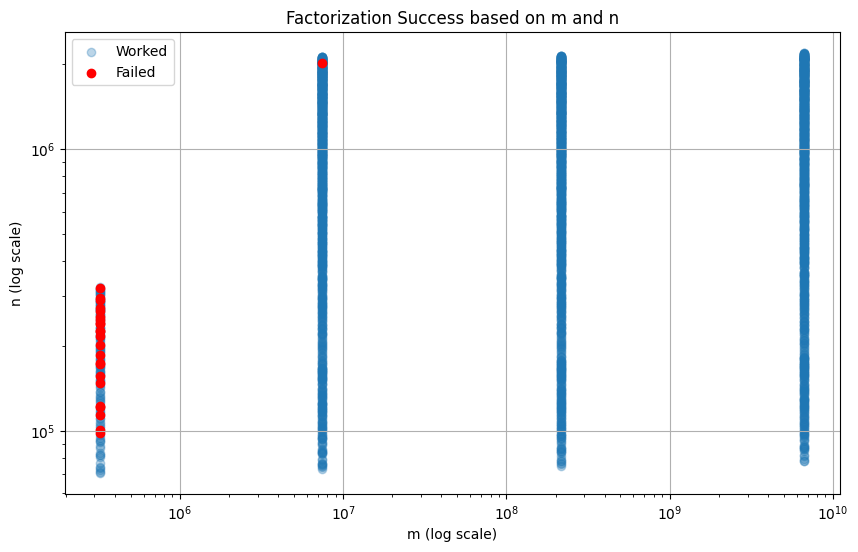

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(results[results['worked'] == True]['m'], results[results['worked'] == True]['n'], alpha=0.3, label='Worked')
plt.scatter(results[results['worked'] == False]['m'], results[results['worked'] == False]['n'], color='red', label='Failed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('m (log scale)')
plt.ylabel('n (log scale)')
plt.title('Factorization Success based on m and n')
plt.legend()
plt.grid(True)
plt.show()

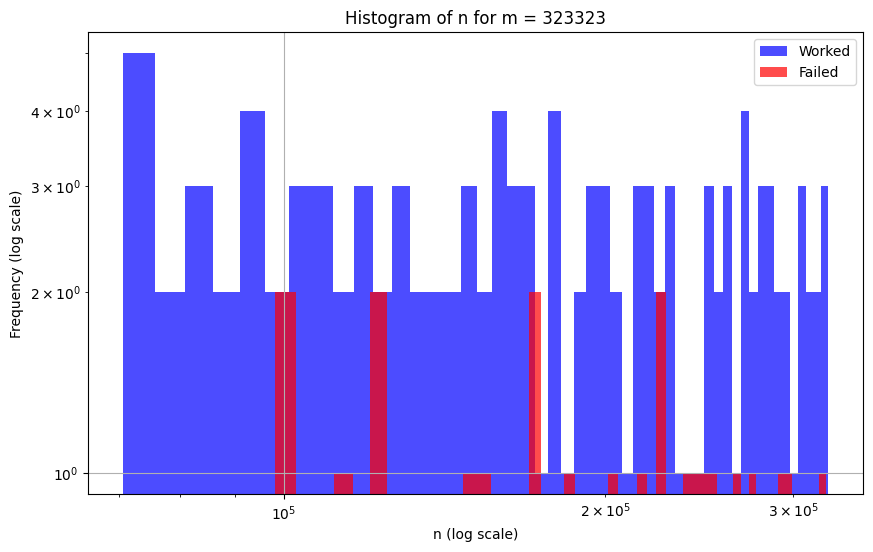

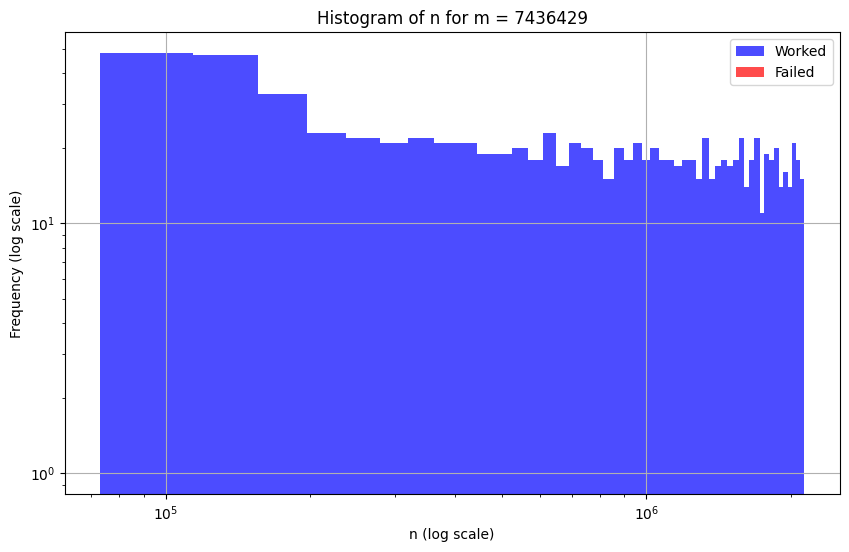

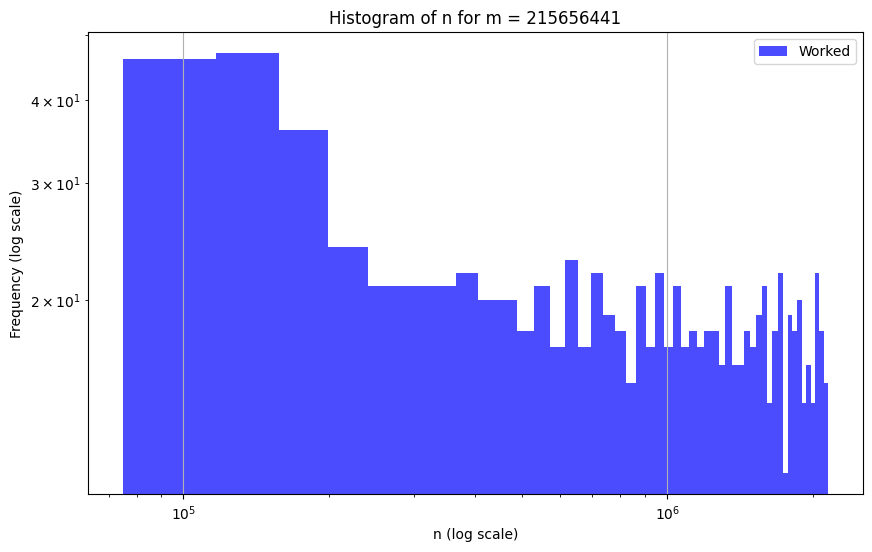

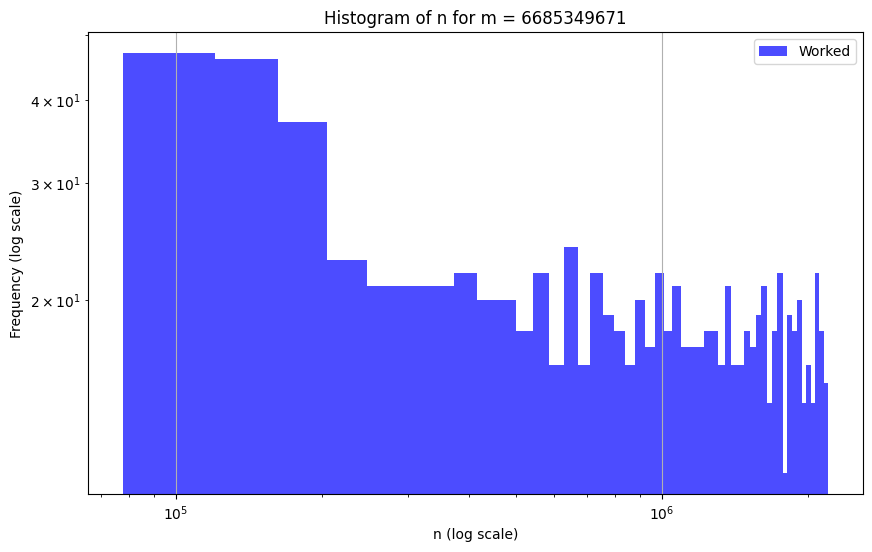

In [29]:
import numpy as np
import matplotlib.pyplot as plt

for m_value in results['m'].unique():
    plt.figure(figsize=(10, 6))
    subset = results[results['m'] == m_value]

    # Plot histogram for successful factorizations
    worked_n = subset[subset['worked'] == True]['n']
    plt.hist(worked_n, bins=50, alpha=0.7, label='Worked', color='blue', log=True)

    # Plot histogram for failed factorizations
    failed_n = subset[subset['worked'] == False]['n']
    if not failed_n.empty:
        plt.hist(failed_n, bins=50, alpha=0.7, label='Failed', color='red', log=True)

    plt.xscale('log')
    plt.xlabel('n (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Histogram of n for m = {m_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

At a glance, it looks like this works more often when $m$ is larger...

## Trying larger numbers

What if we try factoring $n$ which is near $m$?

In [30]:
def prime_in_interval(lo, hi):
  """Gets a prime in the interval [lo, hi)."""
  while True:
    x = sympy.randprime(lo, hi)
    if x >= lo and x < hi:
      return x
  return None

def prime_near(m, fraction_less=0.1):
    return prime_in_interval(int((1-fraction_less)*m), m)

prime_near(1e8)

94434673

In [31]:
def check_factoring(small_primes, num_to_check = 1000):
    """Checks whether this works, for largish numbers.

    small_primes: the primes to use
    max_to_check: the maximum number of values of n to check

    Returns: a list of dicts, with keys "m", "n", and "worked".
    """
    m = math.prod(small_primes)
    max_small_prime = max(small_primes)
    # using a list of dicts, for easy conversion to a dataframe
    results = []
    for num_checked in range(num_to_check):
        a = prime_near(math.sqrt(m))
        b = prime_near(math.sqrt(m))
        n = a * b
        if n <= max_small_prime or n >= m:
            continue

        # Attempt to factor n with y=1
        try:
            # print(f"Calling factor with n={n}, small_primes={small_primes}, max_y=1")
            result = factor(n, small_primes, max_y=1)
            if result is not None:
                results.append({"m": m, "n": n, "worked": True})
            else:
                results.append({"m": m, "n": n, "worked": False})
        except ValueError as e:
            print(f"Error factoring n={n} with m={m}: {e}")

    return results

# Find the index of the first prime that is 7 or larger
start_index_small_primes = next((i for i, prime in enumerate(all_primes) if prime >= 7), 0)


In [32]:
primes = all_primes[start_index_small_primes : start_index_small_primes + 10]
results = check_factoring(primes, num_to_check=100)
results = pd.DataFrame(results)
results.head()

,m,n,worked
0,10141675450907,8840614959019,False
1,10141675450907,9339238323949,False
2,10141675450907,9052574165801,False
3,10141675450907,9383160170381,False
4,10141675450907,9444374892451,False


In [33]:
results.worked.mean()

np.float64(0.21)

So, this isn't working all the time, and required trying $2^{20} \approx 1^6$ numbers. However, this may be *slightly* faster than trial division.

## Choice of primes

Does this work when the small primes are larger (e.g. not starting at 7)?

In [39]:
primes = all_primes[start_index_small_primes+30 : start_index_small_primes + 35]
results = check_factoring(primes, num_to_check=100)
results = pd.DataFrame(results)
results.head()

,m,n,worked
0,80032295351,68312165507,False
1,80032295351,74191866451,False
2,80032295351,78028250873,False
3,80032295351,73619377841,False
4,80032295351,73416574207,False


In [40]:
results.worked.mean()

np.float64(0.0)

It *definitely* didn't work with this set of primes; it looks like you need to include smaller primes.